In [1]:
import numpy as np
import seaborn as sns; sns.set()
sns.set(color_codes=True)
sns.set(font_scale=1.2)
import sys
sys.path.append(r"../src")
from visulizer import *
from feature_importance_helper import *
from feature_interaction_score_utilities import *
from FIS_explainer import fis_explainer
from Utilities import *
#plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Load data from csv file

In [2]:
X_df = load_data(filename='../data/data_withLattice.csv')
X_features = X_df.iloc[:,1:-5]
feature_names = X_features.columns.values

y_multilabel = X_df.iloc[:,-5:]
label_names = y_multilabel.columns.values

print('Feature names: \n', feature_names)
print('Label names: ', label_names)

Feature names: 
 ['Sc' 'Ti' 'V' 'Cr' 'Zr' 'Nb' 'Mo' 'Hf' 'Ta' 'C' 'N' 'F' 'H' 'O' 'OH'
 'NULL' 'Li' 'Na' 'K' 'Mg']
Label names:  ['Voltage(V)' 'Theoretical_capacity (mAh/g)' 'Induced_Z_charge(mAh/g)'
 'In-plane lattice' 'In-plane lattice(intercalated)']


## MXen descriptor

In [3]:
data_index = []
for index, row in X_features.iterrows():
    indices = [i for i, x in enumerate(row) if x == 1]
    indices[1] = indices[1]-9
    indices[2] = indices[2]-11
    indices[3] = indices[3]-16
    data_index.append(indices)
X_features_classes = np.array(data_index)

In [4]:
X = X_features.to_numpy()
y = y_multilabel.to_numpy()
scaler = preprocessing.MinMaxScaler()
y = scaler.fit_transform(y)

In [8]:
from torch.utils.data import Dataset, TensorDataset
import torch
X_train, X_test, y_train, y_test = train_test_split(X_features_classes, y, test_size=0.2, random_state=42)
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [9]:
from train import Net
model = Net()
model.load_state_dict(torch.load('../results/model/best_model_ANN_mx_descriptor.pth'))
model.eval()

Net(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [10]:
print('The loss of trained NN on the test set is {}, training process is illustrated below'.format(mean_squared_error(y_test, model(X_test_tensor).detach().numpy())))
train_loss = np.load('../results/model/train_loss_mx_descriptor.npy')
test_loss = np.load('../results/model/test_loss_mx_descriptor.npy')

The loss of trained NN on the test set is 0.005243746395260729, training process is illustrated below


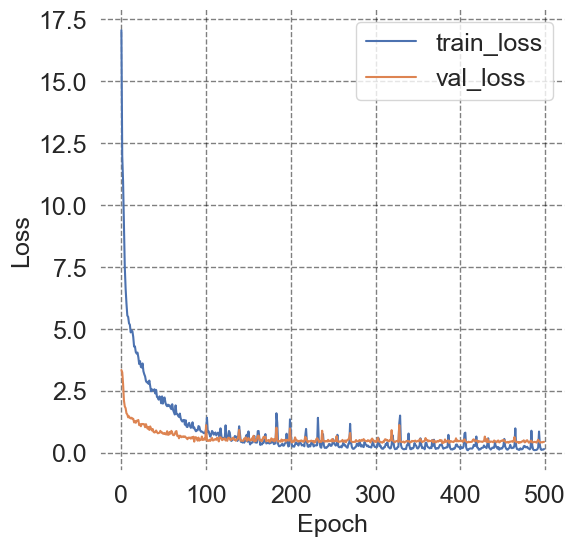

In [11]:
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111)
ax.plot(train_loss[:], label='train_loss')
ax.plot(test_loss[:], label='val_loss')
ax.set_axisbelow(True)
ax.xaxis.grid(False, color ="black", linestyle='--', lw = 1, alpha=0.5)
ax.yaxis.grid(False, color ="black", linestyle='--', lw = 1, alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_facecolor("white")
ax.legend(bbox_to_anchor=(1.0, 1.0), shadow=False, facecolor='white', fontsize=18)
ax.set_xlabel('Epoch',fontsize=18)
ax.set_ylabel('Loss',fontsize=18)
plt.savefig('../results/figs/training_process_mx_descriptor.png', bbox_inches='tight')
plt.show()

### PCA with NN and RF

### NN results

In [14]:
from sklearn.manifold import TSNE
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
# tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = pca.fit_transform(y_test)
z_pred = pca.fit_transform((model(X_test_tensor).detach().numpy()))

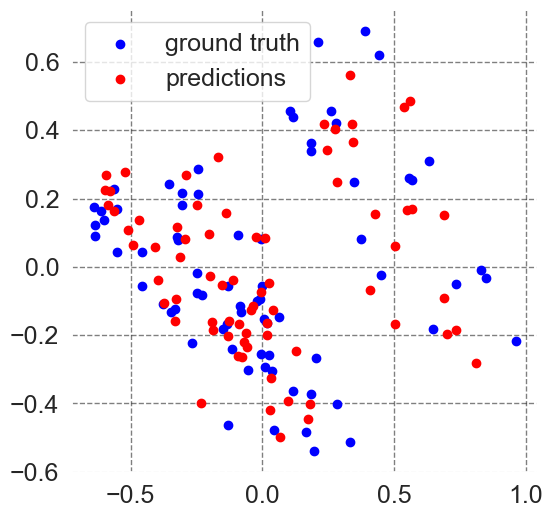

In [15]:
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111)
ax.scatter(z[:,0], z[:,1], color='blue', label='ground truth')
ax.scatter(z_pred[:,0], z_pred[:,1], color='red', label='predictions')
# ax.set_axisbelow(True)
ax.xaxis.grid(False, color ="black", linestyle='--', lw = 1, alpha=0.5)
ax.yaxis.grid(False, color ="black", linestyle='--', lw = 1, alpha=0.5)
# ax.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_facecolor("white")
ax.legend(loc=2, shadow=False, facecolor='white', fontsize=18)
# ax.set_xlabel('PCA',fontsize=18)
plt.savefig('../results/figs/pred_vs_gth_nn_mx_descriptor.png', bbox_inches='tight')
plt.show()



## Apply new framework

In [16]:
import os
ROOT_DIR = os.getcwd()
OUTPUT_DIR = ROOT_DIR+'/../results'

In [31]:
fis_explainer_mlp = fis_explainer(model, X_test, y_test, epsilon_rate=0.1, loss_fn='regression', wrapper_for_torch=True)

In [71]:
content_in_results=os.listdir(OUTPUT_DIR)
analysis_results = {'FIS-in-Rashomon-set':{'saved':False, 'path':'', 'variable_name':'FIS_in_Rashomon_set'},
                    'FIS-joint-effect-raw':{'saved':False, 'path':'', 'variable_name':'rset_joint_effect_raw'},
                    'FIS-main-effect-raw':{'saved':False, 'path':'', 'variable_name':'rset_main_effect_raw'},'FIS-main-effect-processed':{'saved':False, 'path':'', 'variable_name':'rset_main_effect_processed'},'Ref-in-Rashomon-set-analysis':{'saved':False, 'path':'', 'variable_name':'ref_analysis'}}
if len(content_in_results) == 0:
    print('Nothing in the directory {}'.format(OUTPUT_DIR))
else:
    for result in analysis_results:
        for content in content_in_results:
            if result in content:
                analysis_results[result]['saved'] = True
                result_path = OUTPUT_DIR+'/'+content
                analysis_results[result]['path'] = result_path
                att_name = analysis_results[result]['variable_name']
                setattr(fis_explainer_mlp, att_name, load_json(result_path))
                break
        if not analysis_results[result]['saved']:
            print('{} is not in {}'.format(result, content_in_results))

In [32]:
fis_explainer_mlp.ref_explain()

2023-06-27 12:59:50,768 INFO FIS_explainer ref_explain Reference model analysis
2023-06-27 12:59:50,769 INFO FIS_explainer ref_explain Calculating main effect, joint effect and FIS for the reference model
2023-06-27 12:59:50,814 INFO FIS_explainer _get_ref_fis main effects calculated and can be called by explainer.ref_analysis[ref_main_effects]
2023-06-27 12:59:50,814 INFO FIS_explainer _get_ref_fis features with importance 0 are excluded, including []
2023-06-27 12:59:50,881 INFO FIS_explainer _get_ref_fis joint effects calculated and can be called by explainer.ref_joint_effects
2023-06-27 12:59:50,881 INFO FIS_explainer ref_explain FIS calculated and can be called by explainer.ref_analysis
2023-06-27 12:59:50,882 INFO FIS_explainer ref_explain Calculation done


In [33]:
fis_explainer_mlp.rset_explain()

2023-06-27 12:59:55,943 INFO FIS_explainer rset_explain Start exploring the possible models
2023-06-27 12:59:55,944 INFO FIS_explainer _explore_m_in_R Searching models in the Rashomon set ...
2023-06-27 12:59:55,945 INFO feature_importance_helper greedy_search Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss difference 0.0
2023-06-27 12:59:55,946 INFO feature_importance_helper greedy_search Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss difference 0.0
2023-06-27 12:59:55,947 INFO feature_importance_helper greedy_search Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss difference 0.0
2023-06-27 12:59:55,949 INFO feature_importance_helper greedy_search Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss difference 0.0
2023-06-27 12:59:55,961 INFO feature_importance_helper greedy_search Feature 0 at boundary 0.1 * epsilon with m 1.1 achieves loss difference 0.0
2023-06-27 12:59:55,962 INFO feature_importance_helper greedy_search Feature 0 at boundary 

In [34]:
feature_names_mx_descriptor = ['M', 'X', 'T', 'Z']

In [35]:
fis_explainer_mlp.swarm_plot_MR(interest_of_features = [0, 1 ,2 ,3] , vname = feature_names_mx_descriptor, plot_all = True, boxplot = False, save=False, suffix='NN')

TypeError: 'LinearSegmentedColormap' object is not iterable

In [24]:
std = [np.std(i) for i in np.array(fis_explainer_mlp.rset_main_effect_processed['all_main_effects_diff']).transpose(
        (2, 0, 1, 3)).reshape((len(fis_explainer_mlp.v_list), -1))]
std

[0.00070822609915238,
 0.00027194003907508207,
 0.00028205943859177307,
 0.0011859523170622153]

In [48]:
def plot_feature_importance(ft_set, feature_importance, show_cols = 30):

    fig = plt.figure(figsize=(12,4))
    w_lr_sort, ft_sorted, sorted_index_pos = return_feature_importance(ft_set, feature_importance, show_cols = show_cols)
    x_val = list(range(len(w_lr_sort)))
    ax = plt.gca()
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    barlist=plt.bar(x_val, w_lr_sort)
    barlist[0].set_color(colors_vis(c=3))
    barlist[1].set_color(colors_vis(c=1))
    barlist[2].set_color(colors_vis(c=4))
    barlist[3].set_color(colors_vis(c=2))
    plt.xlabel('Feature', fontsize=16)
    plt.ylabel('Ranking', fontsize=16)
    plt.xticks(x_val, ft_sorted, rotation='vertical')

    return fig

def return_feature_importance(ft_set, feature_importance, show_cols = 30):

    w_lr = copy(np.abs(feature_importance))
    w_lr = 100 * (w_lr / w_lr.max())
    sorted_index_pos = [index for index, num in sorted(enumerate(w_lr), key=lambda x: x[-1],
                   reverse=True)]

    ft_sorted = []
    w_lr_sort = []
    for i, idx in enumerate(sorted_index_pos):
        if i > show_cols:
            break
        ft_sorted.append(ft_set[idx])
        w_lr_sort.append(w_lr[idx])

    return w_lr_sort, ft_sorted, sorted_index_pos

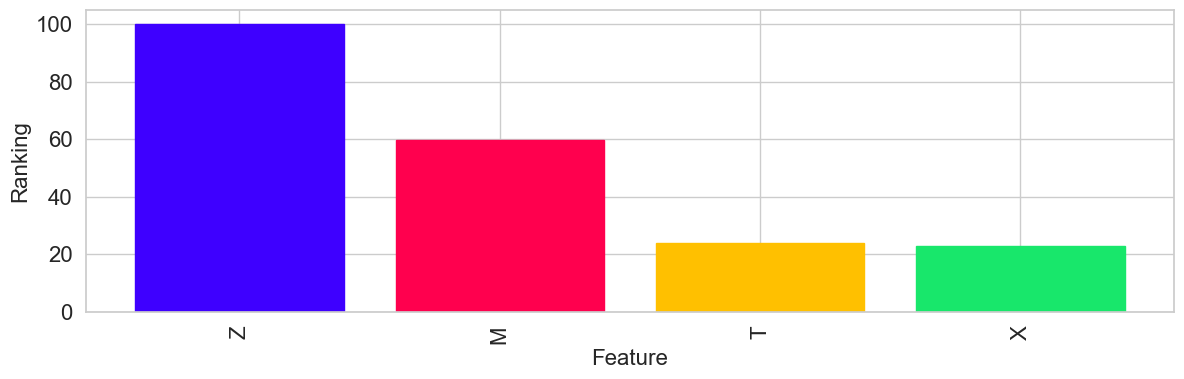

In [50]:
plot_feature_importance(
    feature_names_mx_descriptor,
    std,
    show_cols = 4
)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.savefig('../results/figs/feature_importance_nn_mx_descriptor.png', dpi = 300, bbox_inches='tight')

plt.show()

## save results in a table

In [36]:
results_csv = np.zeros((4, 4))
for idx,i in enumerate(np.array(fis_explainer_mlp.rset_main_effect_processed['all_main_effects_diff']).transpose(
        (2, 0, 1, 3)).reshape((len(fis_explainer_mlp.v_list), -1))):
    results_csv[idx, 0] = np.average(i)
    results_csv[idx, 1] = np.min(i)
    results_csv[idx, 2] = np.max(i)
    results_csv[idx, 3] = np.std(i)
results_csv

array([[0.03845661, 0.03674165, 0.04095638, 0.000738  ],
       [0.00405468, 0.00344267, 0.00465044, 0.00024721],
       [0.01014539, 0.00933976, 0.01079455, 0.00031393],
       [0.05804974, 0.05485592, 0.06144604, 0.00114806]])

In [37]:
np.savetxt("../results/figs/result_mx_descriptor.csv", results_csv, delimiter=",")